# Multas de tránsito en USA

Las infracciones de tráfico siguieron a la invención del automóvil: la primera multa de tráfico en los Estados Unidos supuestamente se le dio a un taxista de la ciudad de Nueva York el 20 de mayo de 1899 por ir a la vertiginosa velocidad de 12 millas por hora (aprox. 19.3 km/h). Desde entonces, se han emitido innumerables citaciones por infracciones de tránsito en todo el país, y los estados han cosechado miles de millones de dólares en ingresos de los infractores.

Las infracciones de tránsito generalmente se dividen en tipos de infracciones mayores y menores. El tipo más leve son las infracciones de estacionamiento, que no se cuentan en el historial de manejo, aunque una persona puede ser arrestada por infracciones no pagadas.

El tipo más común de infracción de tránsito es la infracción del límite de velocidad. Los límites de velocidad están definidos por estado.

El dataset fue obtenido de Kaggle: https://www.kaggle.com/datasets/felix4guti/traffic-violations-in-usa

In [1]:
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.optimize import curve_fit
import matplotlib.dates as mdates
matplotlib.rcParams['figure.figsize'] = [16,5]
import warnings
warnings.filterwarnings("ignore")
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.stattools import adfuller, kpss
from scipy import stats
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

### Gráfica de la serie original - Lectura de datos

In [2]:
# Carga del dataset
inputfile="Traffic_Violations.csv"
print('Input file is:', inputfile)
df = pd.read_csv(inputfile)
df = df.rename(columns={'Date Of Stop': 'fecha_detencion'})
df = df.set_index(pd.DatetimeIndex(df['fecha_detencion']))
df.sort_index(ascending=True, inplace=True)
df["Count"] = 1
df = df["Count"]

df = df.groupby("fecha_detencion").count()
# Informacion general
df.info()


Input file is: Traffic_Violations.csv
<class 'pandas.core.series.Series'>
DatetimeIndex: 1822 entries, 2012-01-01 to 2016-12-27
Series name: Count
Non-Null Count  Dtype
--------------  -----
1822 non-null   int64
dtypes: int64(1)
memory usage: 28.5 KB


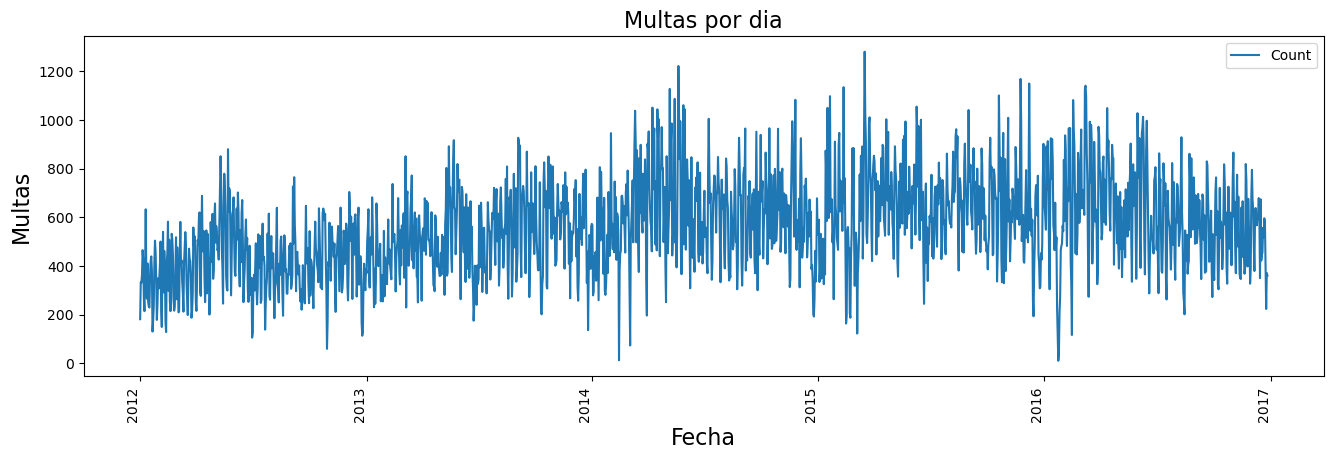

In [3]:
matplotlib.rcParams['figure.figsize'] = [16,5]
plt.figure()
ax = df.plot(y='Count', rot=90)
ax.set_title("Multas por dia", fontsize=16)
ax.set_ylabel("Multas", fontsize=16)
ax.set_xlabel("Fecha", fontsize=16)
plt.legend(loc='best')
plt.show()

### Logarítmica con diferenciacion a 7 días

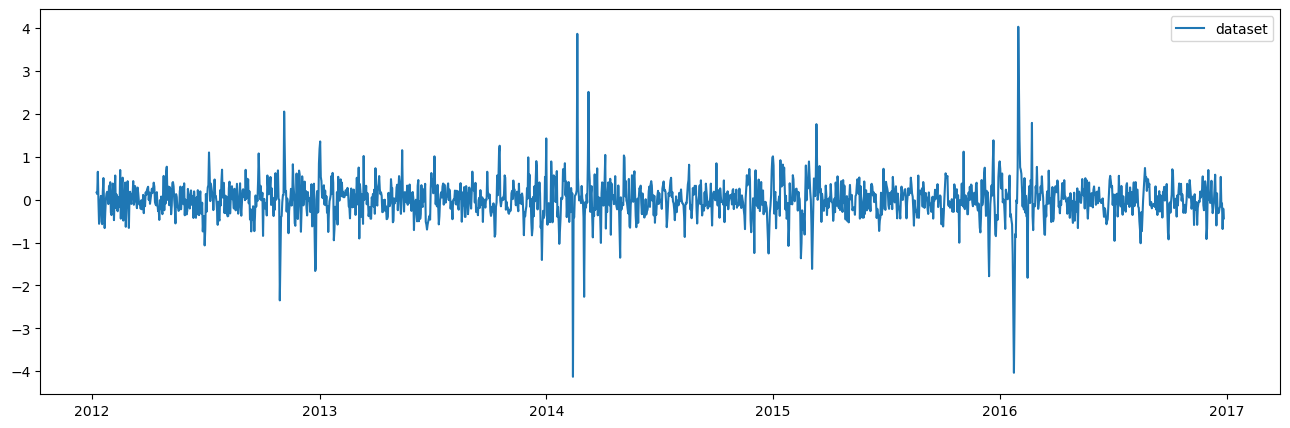

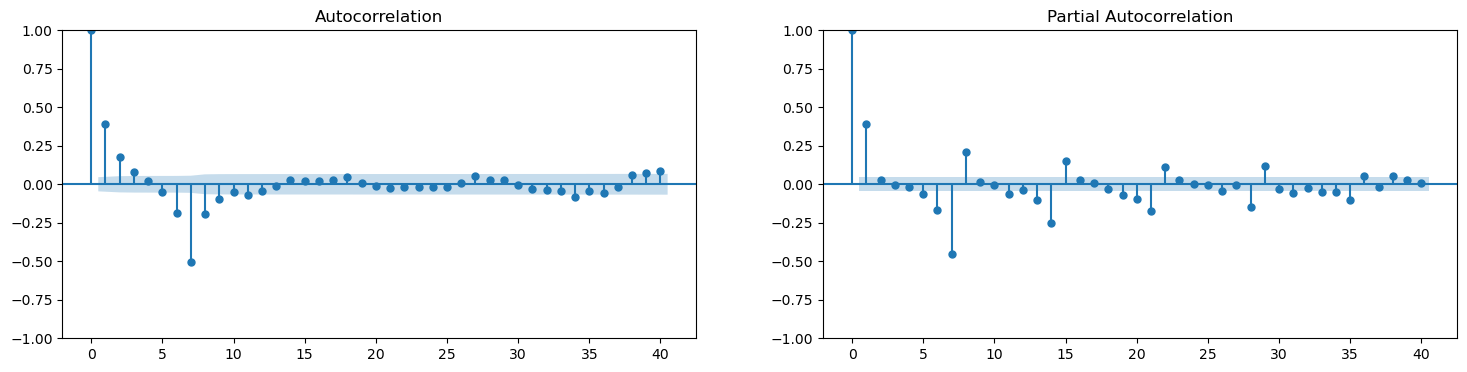

In [4]:
dataset = np.log(df)
diff = dataset.diff(7).dropna()

plt.plot(diff)
plt.legend(['dataset'])
plt.show()

fig, ax = plt.subplots(1,2,figsize=(18,4))
plot_acf(diff, ax=ax[0], lags=40)
plot_pacf(diff, method='ywm', ax=ax[1], lags=40);

In [5]:
adfuller(diff)

(-13.083296915248509,
 1.8517075610231567e-24,
 21,
 1793,
 {'1%': -3.434002362895342,
  '5%': -2.863153315036348,
  '10%': -2.5676288771043367},
 1052.7814940882604)

In [6]:
kpss(diff)

(0.018690954793363974,
 0.1,
 11,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

### Observaciones   

El mejor valor de adfuller y kpss para la determinación de la estacionariedad de la serie es aplicando una transformación logarítmica y luego una diferenciación de 7 dias.

### Modelos (S)ARIMA

#### MODELO 1 

Primer modelo a testear

- Para MA miro la grafica de Autocorrelacion y puedo proponer q = 2 , ya que en el primer ciclo (7 lags) veo que fuera de la banda "cero" hay aprox. 4 componentes fuera de el pero se evaluarán diferentes valores y se decide comenzar por un valor chico.

- Para AR miro la grafica de Autocorrelacion parcial, p = 2, por lo cual con el mismo criterio que q, comenzaremos con valor 1

- d = 0 No se realiza diferenciacion en la parte estacionaria.

- D = 1 ya que hice 1 diferenciacion con 7 dias o pasos.

- P = 1

- Q = 1 

- s= 7 Con este valor tomo un seasonal de 7 dias


In [7]:
model = ARIMA(np.log(df), order=(1,0,2), seasonal_order=(1,1,1,7))
fitted_model = model.fit()
summary_model1 = fitted_model.summary()
summary_model1


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Count   No. Observations:                 1822
Model:             ARIMA(1, 0, 2)x(1, 1, [1], 7)   Log Likelihood                -384.981
Date:                           Thu, 20 Apr 2023   AIC                            781.962
Time:                                   12:34:57   BIC                            814.985
Sample:                                        0   HQIC                           794.147
                                          - 1822                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7040      0.068     10.325      0.000       0.570       0.838
ma.L1         -0.2882      0.070     -4.142      0.000      -0.425      -0.152
ma.L2         -0.0934      0.042     -2.215      0.027      -0.176      -0.011
ar.S.L7        0.0006      0.026      0.024      0.981      -0.050       0.051
ma.S.L7       -0.9375      0.010    -93.036      0.000      -0.957      -0.918
sigma2         0.0888      0.001    102.565      0.000       0.087       0.090
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             61246.56
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.14   Skew:                            -2.88
Prob(H) (two-sided):                  0.12   Kurtosis:                        30.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Analisis de los residuos


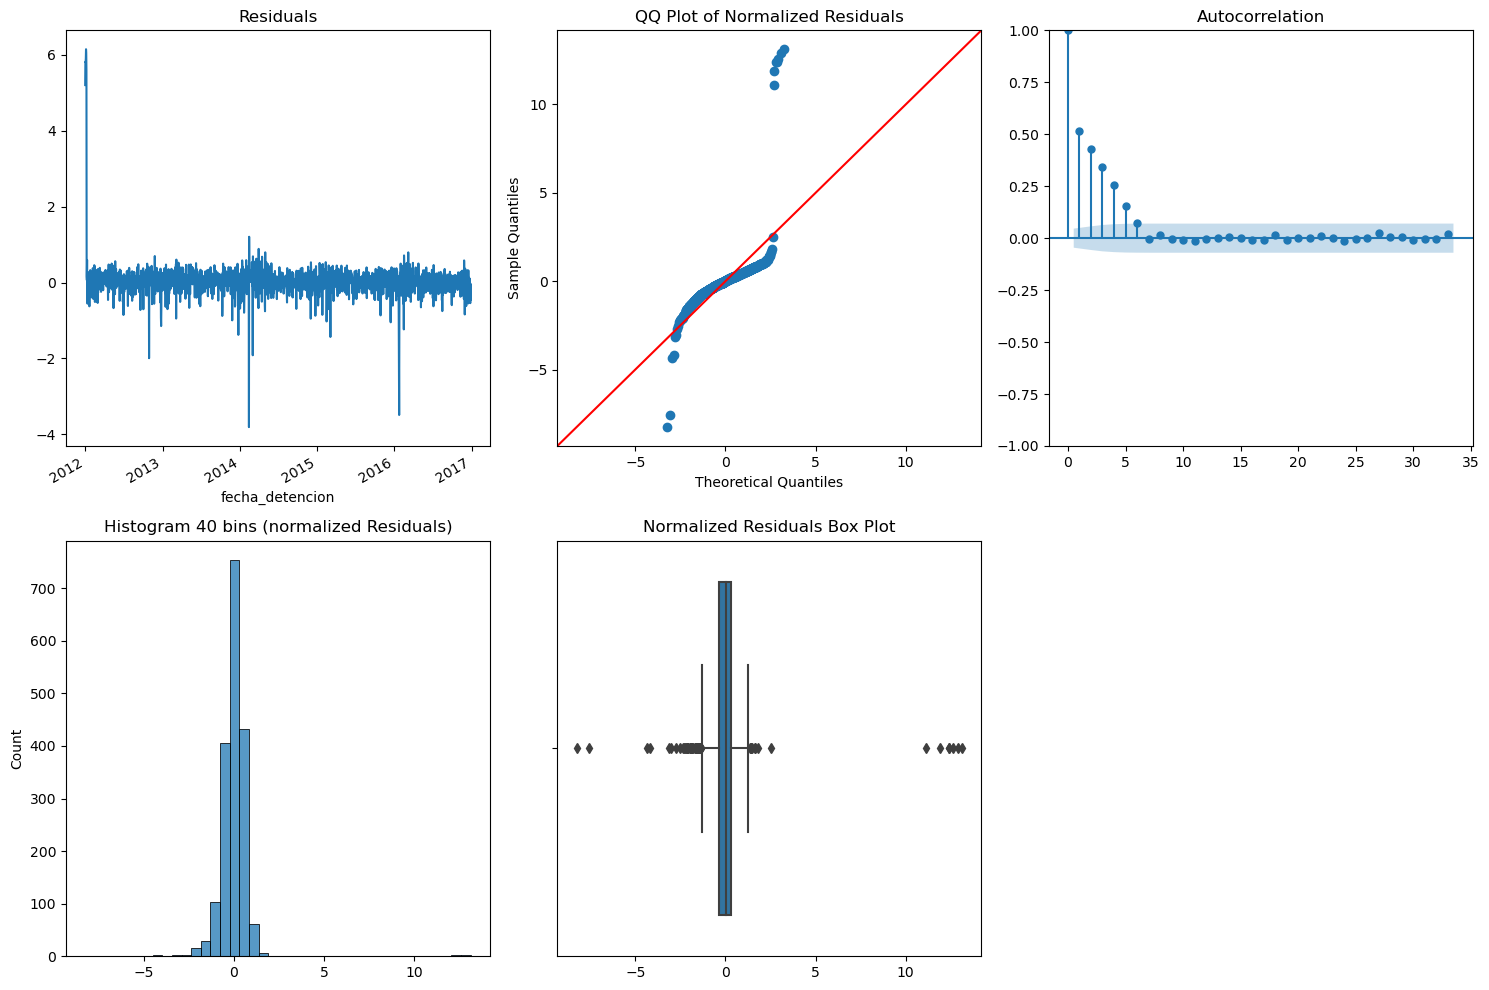

In [8]:

resid = fitted_model.resid
resid_norm = (resid-resid.mean())/resid.std()
bins=40

#Plot
fig, ax = plt.subplots(2,3,figsize=(15,10))
resid.plot(ax=ax[0,0])
ax[0,0].set_title('Residuals')
sm.qqplot(resid_norm, scale=1, line="45", ax=ax[0,1])
ax[0,1].set_title('QQ Plot of Normalized Residuals')
sm.graphics.tsa.plot_acf(resid, ax=ax[0,2])
sns.histplot(resid_norm, bins=bins, ax=ax[1,0])
ax[1,0].set_title(f'Histogram {bins} bins (normalized Residuals)')
sns.boxplot(resid_norm, ax=ax[1,1])
ax[1,1].set_title('Normalized Residuals Box Plot')
plt.delaxes(ax[1][2])
plt.tight_layout()
plt.show()

#### CONCLUSION MODELO 1

El p-valor de Ljung-Box es > 0.05 por lo tanto no rechazo, es un valor alto, por lo cual podemos decir que los residuos están descorrelacionados.


### MODELO 2

Segundo modelo a testear

- Para AR - p = 2

- Para MA - q = 2

- d = 0 No se diferencia el estacionario

- D = 1 ya que hice 1 diferenciacion con 7 dias o pasos.

- P = 1 seasonal de AR

- Q = 1 seasonal de MA

- s= 7 Con este valor tomo un seasonal de 7 dias

In [9]:
model2 = ARIMA(np.log(df), order=(2,0,2), seasonal_order=(1,1,1,7))
fitted_model2 = model2.fit()
fitted_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Count   No. Observations:                 1822
Model:             ARIMA(2, 0, 2)x(1, 1, [1], 7)   Log Likelihood                -381.320
Date:                           Thu, 20 Apr 2023   AIC                            776.641
Time:                                   12:35:03   BIC                            815.167
Sample:                                        0   HQIC                           790.856
                                          - 1822                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3769      0.099     13.900      0.000       1.183       1.571
ar.L2         -0.4035      0.083     -4.853      0.000      -0.566      -0.241
ma.L1         -0.9681      0.103     -9.432      0.000      -1.169      -0.767
ma.L2          0.0404      0.068      0.594      0.552      -0.093       0.174
ar.S.L7       -0.0010      0.026     -0.038      0.970      -0.053       0.051
ma.S.L7       -0.9458      0.010    -95.642      0.000      -0.965      -0.926
sigma2         0.0876      0.001    100.466      0.000       0.086       0.089
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):             62568.17
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               1.15   Skew:                            -2.91
Prob(H) (two-sided):                  0.08   Kurtosis:                        31.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

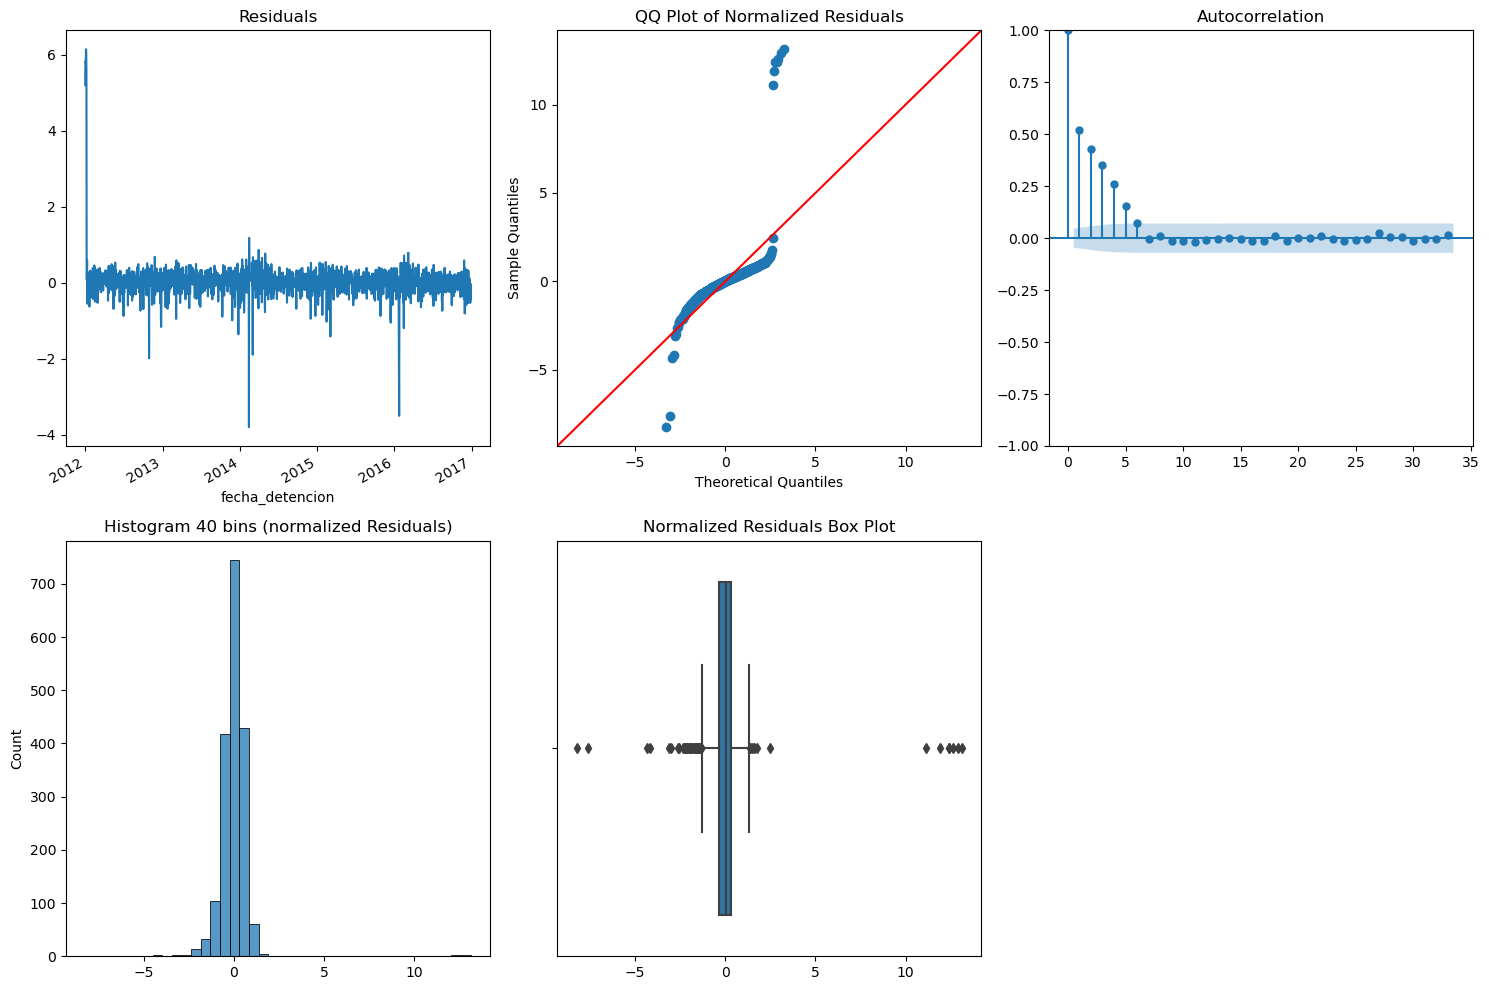

In [10]:
resid = fitted_model2.resid
resid_norm = (resid-resid.mean())/resid.std()
bins=40

#Plot
fig, ax = plt.subplots(2,3,figsize=(15,10))
resid.plot(ax=ax[0,0])
ax[0,0].set_title('Residuals')
sm.qqplot(resid_norm, scale=1, line="45", ax=ax[0,1])
ax[0,1].set_title('QQ Plot of Normalized Residuals')
sm.graphics.tsa.plot_acf(resid, ax=ax[0,2])
sns.histplot(resid_norm, bins=bins, ax=ax[1,0])
ax[1,0].set_title(f'Histogram {bins} bins (normalized Residuals)')
sns.boxplot(resid_norm, ax=ax[1,1])
ax[1,1].set_title('Normalized Residuals Box Plot')
plt.delaxes(ax[1][2])
plt.tight_layout()
plt.show()

#### CONCLUSION MODELO 2

El p-valor de Ljung-Box es > 0.05 por lo tanto no rechazo, los resultados obtenidos son peores que los del modelo 1 .

En el QQ-Plot se ve mucha curtosis, el valor obtenido es 30, el cual es muy elevado. Por otro lado en el Box-Plot se pueden ver outliers por lo cual se puede decir que al presentar estas caracteristicas se concluye que el modelo no ajusta bien e incluso es peor que el modelo 1.

### MODELO 3

Tercer modelo a testear

- Para AR - p = 4

- Para MA - q = 3

- d = 0

- D = 1 ya que hice 1 diferenciacion con 15 dias o pasos.

- P = 2 seasonal de AR

- Q = 2 seasonal de MA

- s= 7 Con este valor tomo un seasonal de 7 dias

In [11]:
model3 = ARIMA(np.log(df), order=(4,0,3), seasonal_order=(2,1,2,7))
fitted_model3 = model3.fit()
fitted_model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                Count   No. Observations:                 1822
Model:             ARIMA(4, 0, 3)x(2, 1, [1, 2], 7)   Log Likelihood                -380.127
Date:                              Thu, 20 Apr 2023   AIC                            784.254
Time:                                      12:35:16   BIC                            850.300
Sample:                                           0   HQIC                           808.624
                                             - 1822                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0272      0.504     -0.054      0.957      -1.015       0.960
ar.L2          0.7442      0.381      1.952      0.051      -0.003       1.491
ar.L3          0.5324      0.467      1.139      0.255      -0.383       1.448
ar.L4         -0.3037      0.163     -1.865      0.062      -0.623       0.015
ma.L1          0.4472      0.508      0.880      0.379      -0.549       1.444
ma.L2         -0.5377      0.270     -1.990      0.047      -1.067      -0.008
ma.L3         -0.7251      0.431     -1.683      0.092      -1.569       0.119
ar.S.L7       -0.6571      0.448     -1.466      0.143      -1.536       0.221
ar.S.L14       0.0212      0.029      0.730      0.465      -0.036       0.078
ma.S.L7       -0.2943      0.446     -0.660      0.509      -1.168       0.580
ma.S.L14      -0.6223      0.421     -1.477      0.140      -1.448       0.204
sigma2         0.0883      0.001     90.829      0.000       0.086       0.090
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):             60622.15
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               1.15   Skew:                            -2.87
Prob(H) (two-sided):                  0.09   Kurtosis:                        30.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

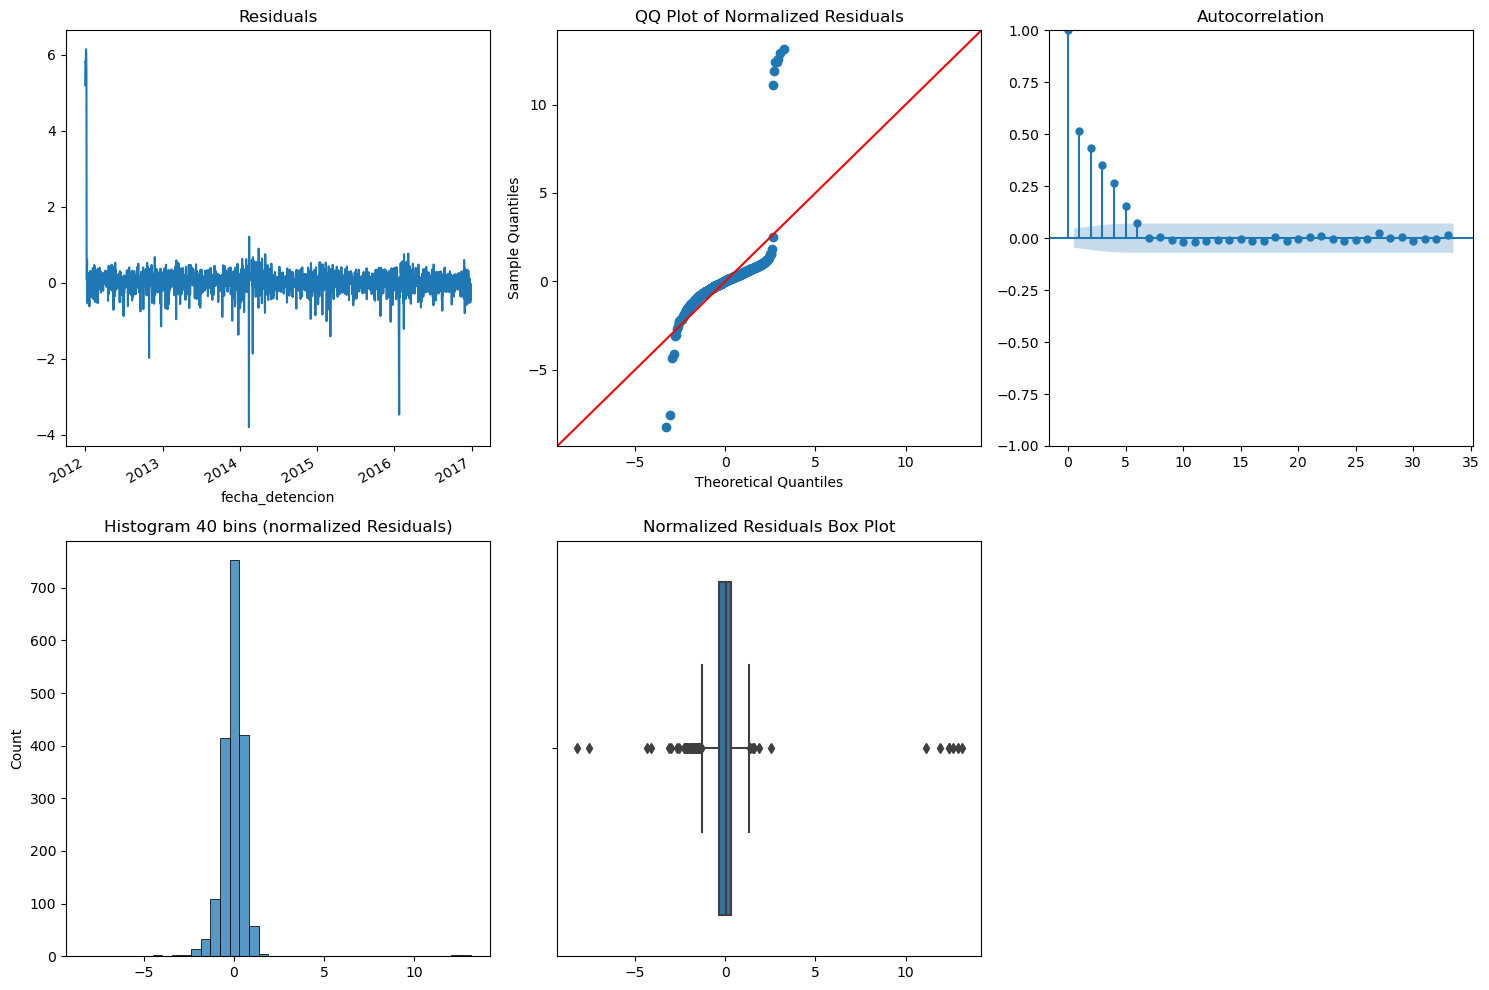

In [12]:
resid = fitted_model3.resid
resid_norm = (resid-resid.mean())/resid.std()
bins=40

#Plot
fig, ax = plt.subplots(2,3,figsize=(15,10))
resid.plot(ax=ax[0,0])
ax[0,0].set_title('Residuals')
sm.qqplot(resid_norm, scale=1, line="45", ax=ax[0,1])
ax[0,1].set_title('QQ Plot of Normalized Residuals')
sm.graphics.tsa.plot_acf(resid, ax=ax[0,2])
sns.histplot(resid_norm, bins=bins, ax=ax[1,0])
ax[1,0].set_title(f'Histogram {bins} bins (normalized Residuals)')
sns.boxplot(resid_norm, ax=ax[1,1])
ax[1,1].set_title('Normalized Residuals Box Plot')
plt.delaxes(ax[1][2])
plt.tight_layout()
plt.show()

#### CONCLUSION MODELO 3

El p-valor de Ljung-Box es > 0.05 por lo tanto no rechazo, el valor es bastante elevado para considerar la descorrelacion de los residuos.

En el QQ-Plot se ve mucha curtosis, el valor obtenido es 30, el cual es muy elevado. Por otro lado en el Box-Plot se pueden ver outliers por lo cual se puede decir que al presentar estas caracteristicas se concluye que el modelo no ajusta bien pero se logro una mejoria en cuanto al modelo anterior pero no al primer modelo. 

### MODELO 4

Cuarto modelo a testear

- Para AR - p = 4

- Para MA - q = 2

- d = 0 Sin diferenciacion estacional

- D = 1 ya que hice 1 diferenciacion con 7 dias o pasos.

- P = 3 seasonal de AR

- Q = 2 seasonal de MA

- s= 7 Con este valor tomo un seasonal de 7 dias

In [13]:
model4 = ARIMA(np.log(df), order=(2,0,4), seasonal_order=(3,1,2,7))
fitted_model4 = model4.fit()
fitted_model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                Count   No. Observations:                 1822
Model:             ARIMA(2, 0, 4)x(3, 1, [1, 2], 7)   Log Likelihood                -381.391
Date:                              Thu, 20 Apr 2023   AIC                            786.783
Time:                                      12:35:36   BIC                            852.829
Sample:                                           0   HQIC                           811.153
                                             - 1822                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7512      0.837      0.898      0.369      -0.889       2.391
ar.L2          0.1244      0.716      0.174      0.862      -1.279       1.528
ma.L1         -0.3379      0.835     -0.405      0.686      -1.974       1.298
ma.L2         -0.2367      0.373     -0.635      0.525      -0.967       0.494
ma.L3         -0.0797      0.141     -0.565      0.572      -0.356       0.197
ma.L4         -0.0466      0.054     -0.857      0.392      -0.153       0.060
ar.S.L7       -0.7056      5.629     -0.125      0.900     -11.739      10.328
ar.S.L14       0.0379      0.070      0.541      0.589      -0.099       0.175
ar.S.L21       0.0328      0.240      0.137      0.891      -0.438       0.504
ma.S.L7       -0.2516      5.629     -0.045      0.964     -11.284      10.780
ma.S.L14      -0.6583      5.328     -0.124      0.902     -11.100       9.783
sigma2         0.0887      0.001     93.321      0.000       0.087       0.091
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             62617.87
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.15   Skew:                            -2.91
Prob(H) (two-sided):                  0.08   Kurtosis:                        31.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

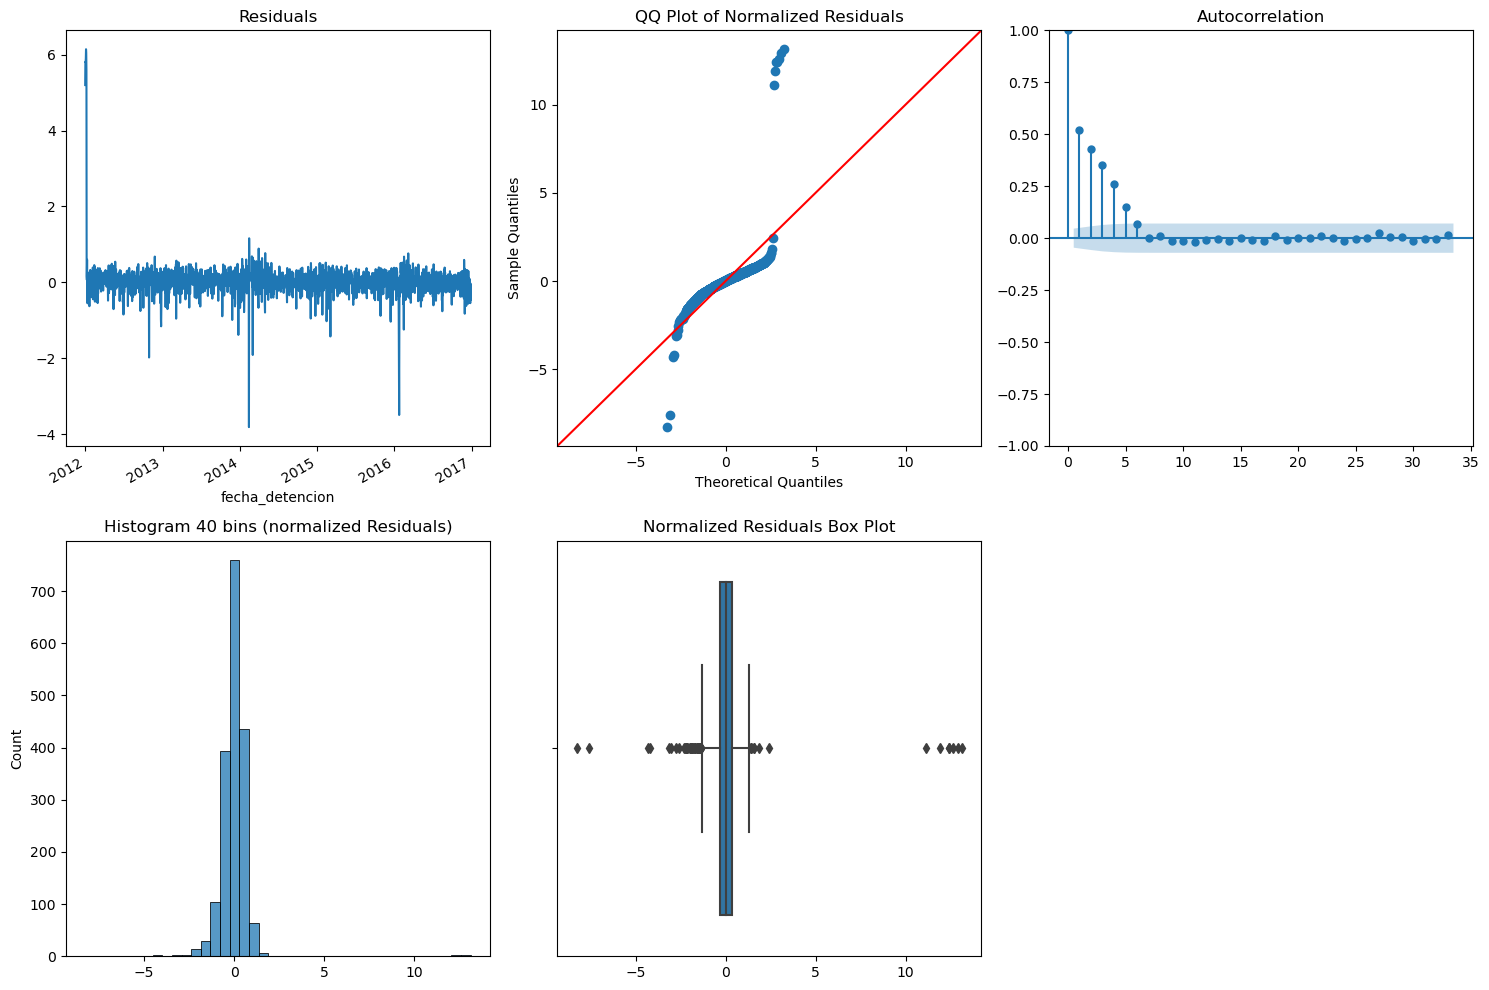

In [14]:
resid = fitted_model4.resid
resid_norm = (resid-resid.mean())/resid.std()
bins=40

#Plot
fig, ax = plt.subplots(2,3,figsize=(15,10))
resid.plot(ax=ax[0,0])
ax[0,0].set_title('Residuals')
sm.qqplot(resid_norm, scale=1, line="45", ax=ax[0,1])
ax[0,1].set_title('QQ Plot of Normalized Residuals')
sm.graphics.tsa.plot_acf(resid, ax=ax[0,2])
sns.histplot(resid_norm, bins=bins, ax=ax[1,0])
ax[1,0].set_title(f'Histogram {bins} bins (normalized Residuals)')
sns.boxplot(resid_norm, ax=ax[1,1])
ax[1,1].set_title('Normalized Residuals Box Plot')
plt.delaxes(ax[1][2])
plt.tight_layout()
plt.show()

#### CONCLUSION MODELO 4

El p-valor de Ljung-Box es > 0.05 por lo tanto no rechazo, el valor es bastante elevado para considerar la descorrelacion de los residuos.

En el QQ-Plot se ve mucha curtosis, el valor obtenido es 30, el cual es muy elevado. Por otro lado en el Box-Plot se pueden ver outliers por lo cual se puede decir que al presentar estas caracteristicas se concluye que el modelo no ajusta bien pero se logro una mejoria en cuanto al modelo anterior pero no al primer modelo. 

### PREDICCION 

Se realizar la prediccion con el modelo 1 que fue elegido por tener mejores metricas que los demas.

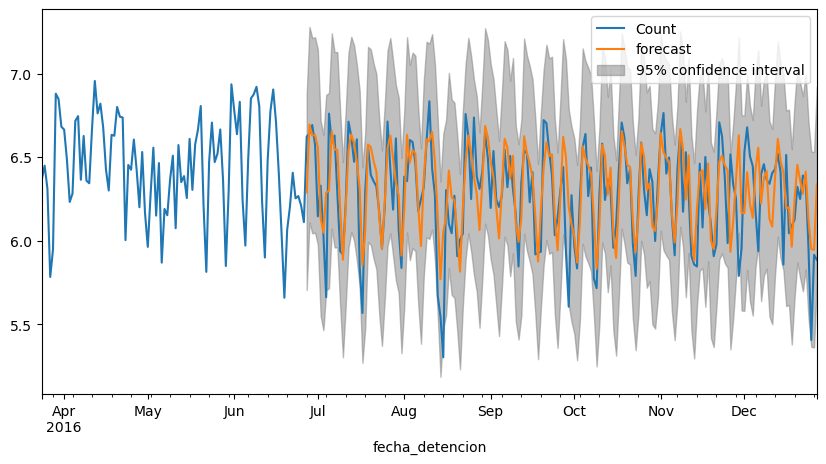

In [15]:
original_data = np.log(df)
fig, ax = plt.subplots(figsize=[10,5])
ax = original_data.loc['2016-03-24':].plot(ax=ax)
fig = plot_predict(fitted_model, start='2016-06-27', end='2016-12-27', ax=ax, plot_insample=False)

plt.show()

### CONSIDERACION DE EVENTOS NO DESEADOS

Como puede observarse en el pre procesamiento de la serie, tenemos eventos que hacen que los valores tomen valores por fuera de los valores normales. Esto puede deberse a acontecimientos particulares de la fecha o bien a datos mal cargados. 

Para mitigar esto se propone utilizar la funcion SARIMAX con variable exogena, donde se realizará un mapeo de los datos que se consideren como outliers o que no tengan aporte con respecto a lo que representa la serie a lo largo de los años de analisis.

#### Analisis y agregado de variable exogena

Se utilizará el modelo 3 para realizar las predicciones.

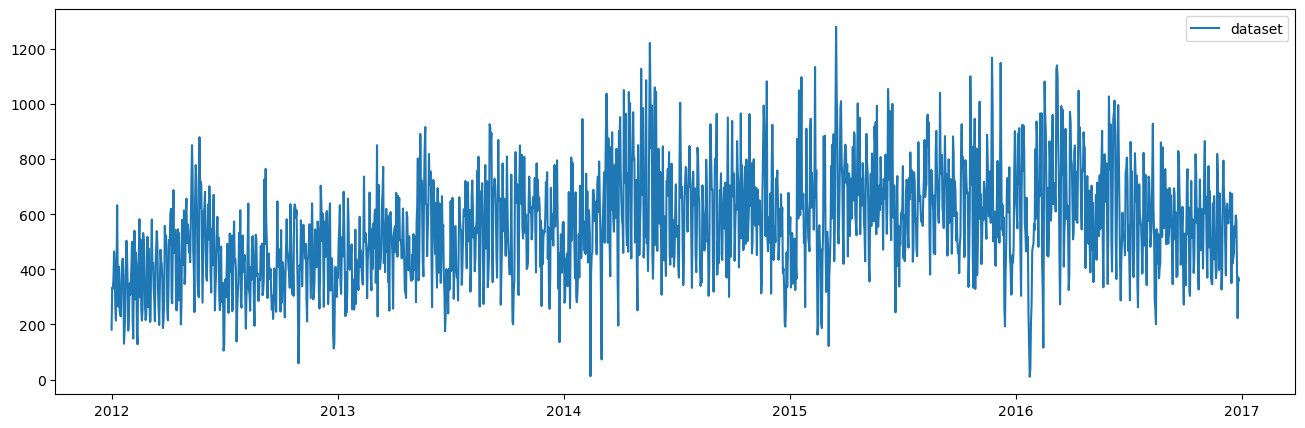

In [16]:

plt.plot(df)
plt.legend(['dataset'])
plt.show()

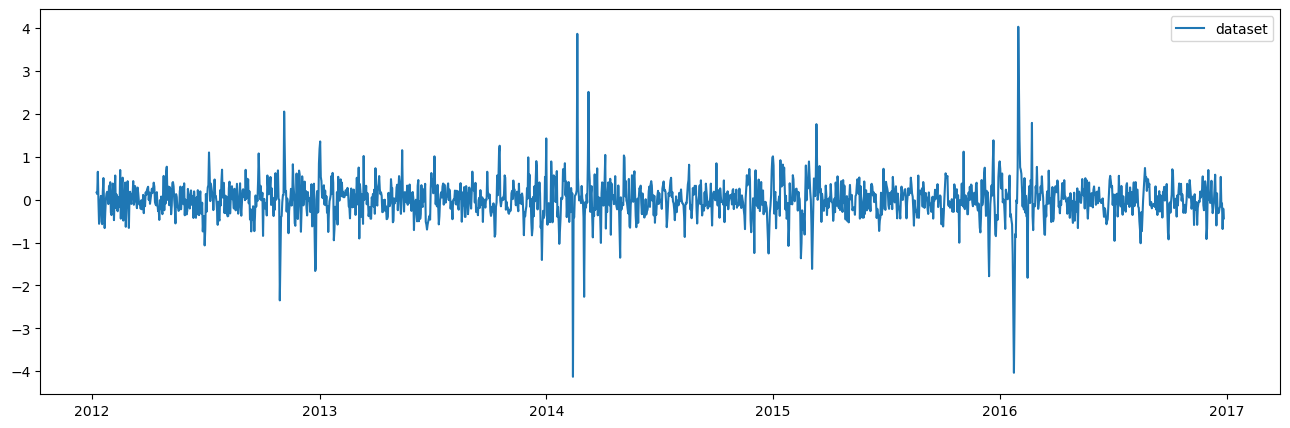

In [17]:
dataset = np.log(df)
diff = dataset.diff(7).dropna()

plt.plot(diff)
plt.legend(['dataset'])
plt.show()



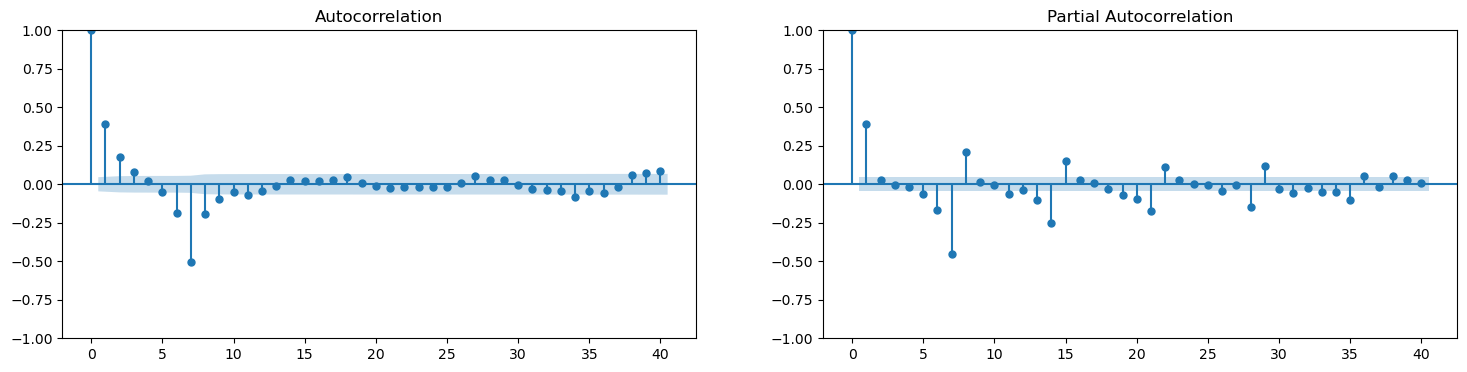

In [18]:

fig, ax = plt.subplots(1,2,figsize=(18,4))
plot_acf(diff, ax=ax[0], lags=40)
plot_pacf(diff, method='ywm', ax=ax[1], lags=40);

In [19]:

exog = np.zeros(len(df))

for i in range(len(diff)):
    if ((diff[i] < -1) | (diff[i] > 1)):
        exog[i] = 1
        


In [20]:
exog
num_valores_distintos_cero = (exog != 0).sum()
num_valores_distintos_cero

49

In [21]:

model5 = SARIMAX(endog = np.log(df), exog = exog, order=(4,0,2), seasonal_order = (2,1,3,7))
model_fit5 = model5.fit(disp=False,method='bfgs')
print(model_fit5.summary())

                                         SARIMAX Results                                         
Dep. Variable:                                     Count   No. Observations:                 1822
Model:             SARIMAX(4, 0, 2)x(2, 1, [1, 2, 3], 7)   Log Likelihood                -306.053
Date:                                   Thu, 20 Apr 2023   AIC                            638.106
Time:                                           12:37:13   BIC                            709.656
Sample:                                                0   HQIC                           664.506
                                                  - 1822                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.5192      0.019    -27.971      0.000    

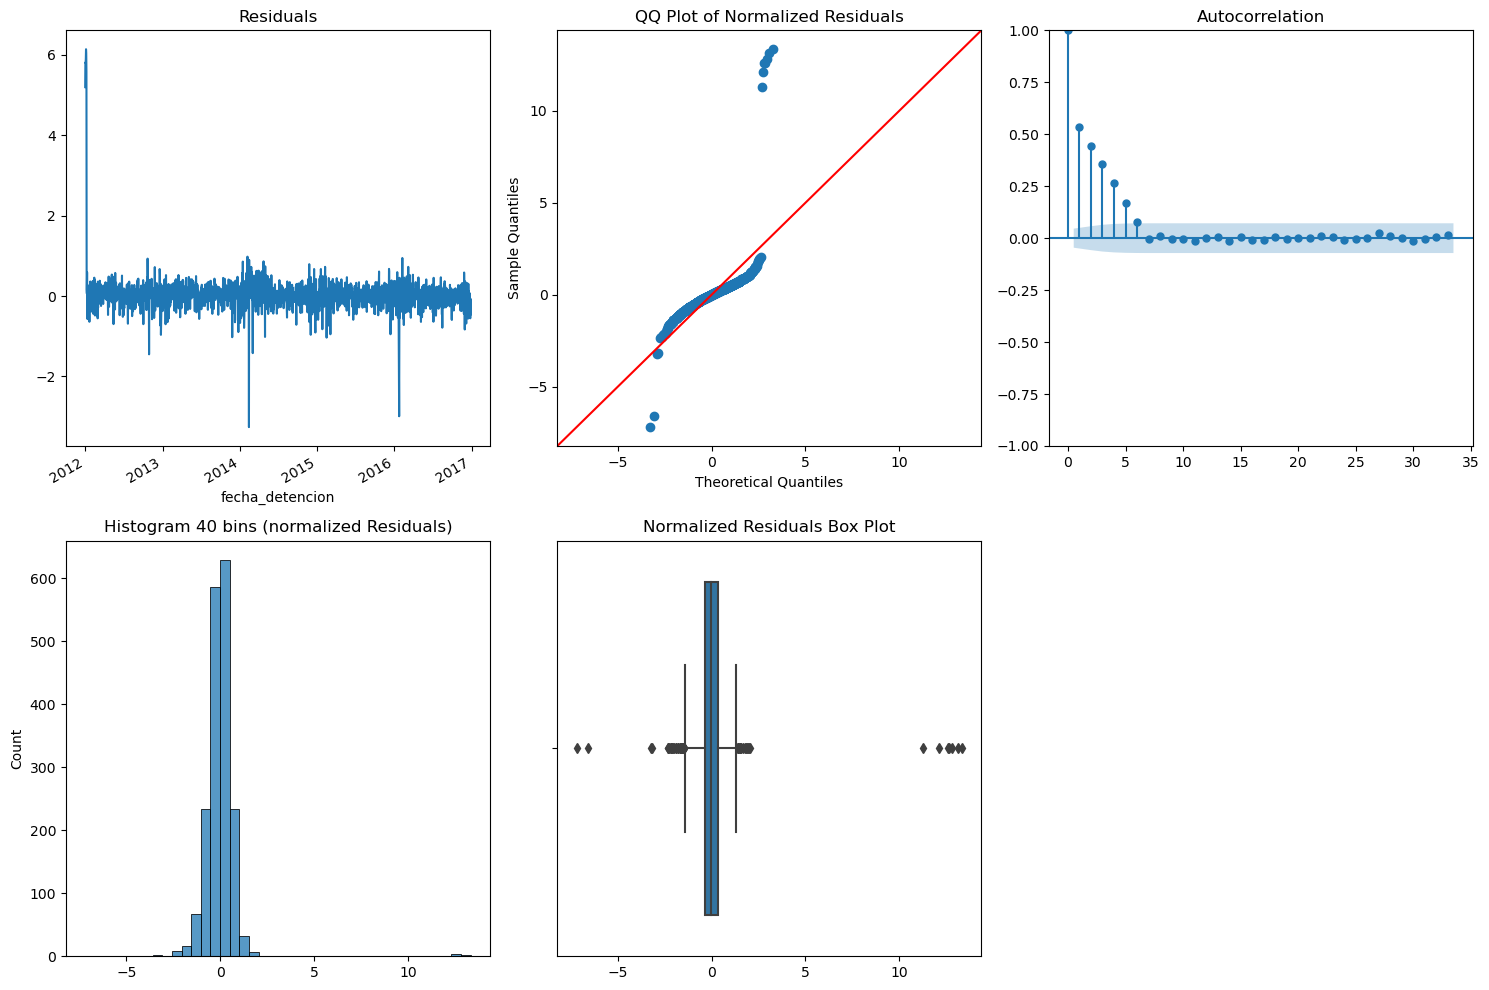

In [22]:
resid = model_fit5.resid
resid_norm = (resid-resid.mean())/resid.std()
bins=40

#Plot
fig, ax = plt.subplots(2,3,figsize=(15,10))
resid.plot(ax=ax[0,0])
ax[0,0].set_title('Residuals')
sm.qqplot(resid_norm, scale=1, line="45", ax=ax[0,1])
ax[0,1].set_title('QQ Plot of Normalized Residuals')
sm.graphics.tsa.plot_acf(resid, ax=ax[0,2])
sns.histplot(resid_norm, bins=bins, ax=ax[1,0])
ax[1,0].set_title(f'Histogram {bins} bins (normalized Residuals)')
sns.boxplot(resid_norm, ax=ax[1,1]) 
ax[1,1].set_title('Normalized Residuals Box Plot')
plt.delaxes(ax[1][2])
plt.tight_layout()
plt.show()

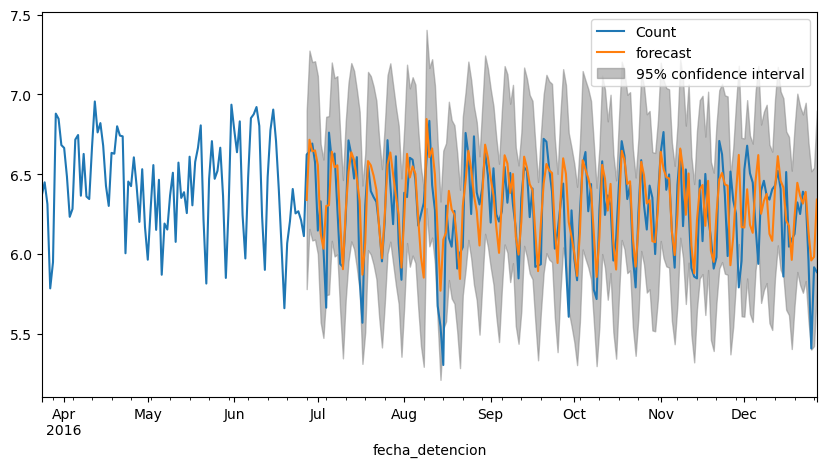

In [23]:
original_data = np.log(df)
fig, ax = plt.subplots(figsize=[10,5])
ax = original_data.loc['2016-03-24':].plot(ax=ax)
fig = plot_predict(model_fit5, start='2016-06-27', end='2016-12-27', ax=ax, plot_insample=False)

plt.show()